<a href="https://colab.research.google.com/github/silasmaverick/jupyter/blob/master/billboard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O projeto se inicia com a instalação de um banco de dados Postgres na nuvem na plataforma Heroku. Heroku é uma plataforma (Paas) que tem a oferta de serviço que permite aos desenvolvedores realizar implantação, escalonamento e gerenciamento de aplicativos sem complicações. Foi construida com base (na Iaas) cloud da AWS

https://devcenter.heroku.com/categories/reference

O primeiro passo foi criar a conta na Heroku. Após a conta criada, É necessário criar um app clicando no botão new. Configurar o nome e preferências. No menu superior, acessar a sessão overview e em seguida configure Addons. No campo de busca escolher Heroku Postgres. 

Criado o serviço, voltar na aba overview e clicar sobre o link do Postgres. Na nova aba, no menu superior escolher Settings e depois view credentials. Ali está as credenciais para manejo do banco de dados.

Para gerenciar o banco de dados usei a IDE dBeaver 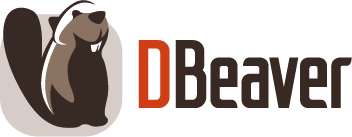

Usei o  dataset https://www.kaggle.com/dhruvildave/billboard-the-hot-100-songs , um arquivo CSV contendo o ranking de músicas da billboard top 100. 

Por limitações do plano Free do heruko (que só permite a inserção de uma carga com 10 mil linhas), vamos analisar o arquivo e modifica-lo para não exceder esse limite.

Para isso vamos usar o Python e sua biblioteca Pandas

In [ ]:
#importação da biblioteca pandas para analise do arquivo CSV
import pandas as pd
#criação do dataframe baseado no CSV
data = pd.read_csv('/home/silas/Downloads/charts.csv')

In [ ]:
#ver uma pequena parte da estrutura do arquivo
data.head()

In [ ]:
#resumo estatístico do dataframe 
data.describe()

Foi constatado que o arquivo possui 328487 linhas. O primeiro lançamento foi em 04/08/1958. Para prosseguir vamos diminuir a quantidade de linhas para analisar um recorte menor de dados e consequentemente poder usar o Postgres Heroku e fazer as consultas SQL
  

In [ ]:
data.iloc[10000]

O registro da linha 10000 mostrou uma música de agosto de 2019. Para não ficar com um ano "picado" vamos usar apenas dados do ano de 2021 e 2020. Também teremos uma gordura para fazer inserções se necessário.

In [ ]:
#Criando um novo dataframe e adicionando os dados com a exclusão usando a data como filtro 
nw1 = data.drop(data[data.date < '2020-01-01'].index)

In [ ]:
#Agora temos pouco mais de 8 mil linhas
nw1.describe()

In [ ]:
#Agora usar o novo arquivo para dar carga no banco de dados a partir dele
nw1.to_csv('blbxxi.csv', index=False)

Com o arquivo em mãos. Vamos criar o esqueleto da tabela no banco de dados. E a importação do arquivo para as linhas e colunas. Os comandos SQL são feitos no dBeaver


In [ ]:
CREATE TABLE PUBLIC."Billboard" (
	"date" DATE NULL
	,"rank" int4 NULL
	,song VARCHAR(300) NULL
	,artist VARCHAR(300) NULL
	,"last-week" int4 NULL
	,"peak-rank" int4 NULL
	,"weeks-on-board" int4 NULL
	);


A seguir alguns exemplos de queries para memorização

- É uma boa pratica colocar um apelido na tabela usando o "as"

In [ ]:
SELECT COUNT(*) as qtd
from public."Billboard" as bil
;

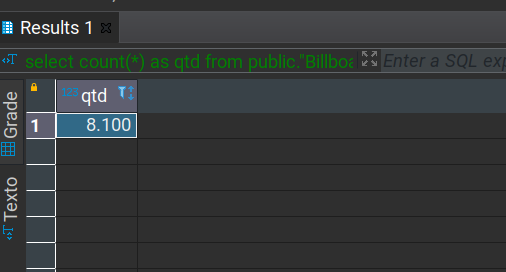

- É uma boa pratica nunca usar o SELECT(*) e sim especificar os nomes das colunas do SELECT
- O site https://poorsql.com/ permite estruturar de forma organizada a query

In [ ]:
SELECT bil."date"
	,bil."rank"
	,bil.artist
	,bil.song	
	,bil."last-week"
	,bil."peak-rank"
	,bil."weeks-on-board"
FROM PUBLIC."Billboard" AS bil limit 10;

Consulta com filtro usando o WHERE:
 - Quais as músicas que mais aparecem da cantora dua lipa?

In [ ]:
SELECT 
	bil.artist
	,bil.song	
FROM PUBLIC."Billboard" AS bil
where bil.artist = 'Dua Lipa';

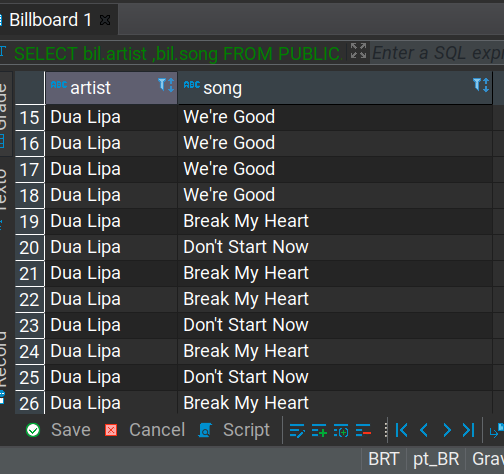

- Usando o distinct para trazer apenas os valores únicos:
 - Obs: Comando pesado. Cuidado ao executar em grandes databases
- Usando o "like" com o "%" para captar mais resultados. Dessa forma, a resposta não se limitará aos caracteres exatos do "WHERE ="

In [ ]:
SELECT distinct 
	bil.artist
	,bil.song	
FROM PUBLIC."Billboard" AS bil
where bil.artist = 'Dua Lipa';

In [ ]:
SELECT distinct 
	bil.artist
	,bil.song	
FROM PUBLIC."Billboard" AS bil
where bil.artist like '%Dua Lipa%';

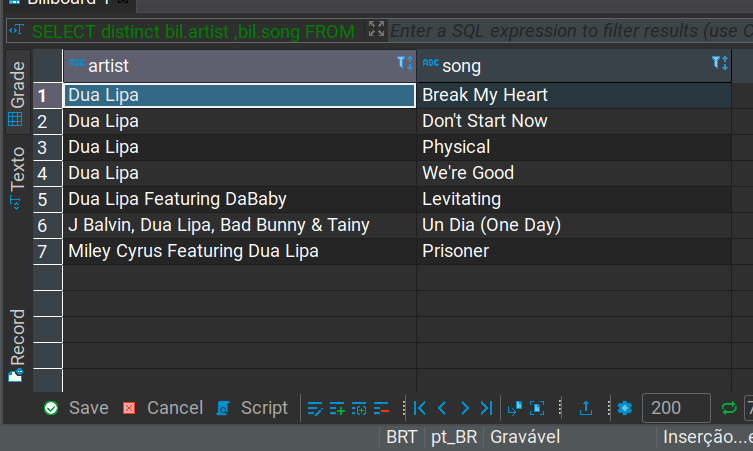

Melhorando a consulta com o count, group by e order by e adicionando outros cantores usando o "in":


In [ ]:
SELECT bil.artist
	,bil.song
	,count(*) AS qtd_musica
FROM PUBLIC."Billboard" AS bil
WHERE bil.artist IN (
		'Dua Lipa'
		,'Olivia Rodrigo'
		,'Ed Sheeran'
		)
GROUP BY bil.artist
	,bil.song
ORDER BY qtd_musica DESC;


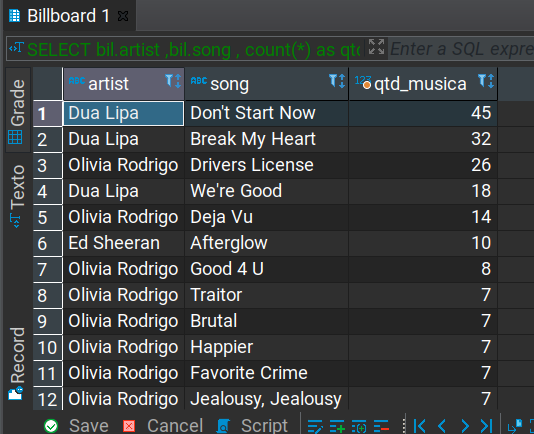

Quais as músicas que mais se repetem no ranking (top 10 músicas)?

In [ ]:
SELECT 	bil.artist
	,bil.song
	, count(*) as qtd_musica
FROM PUBLIC."Billboard" AS bil
group by bil.artist, bil.song 
order by qtd_musica desc 
limit 10;

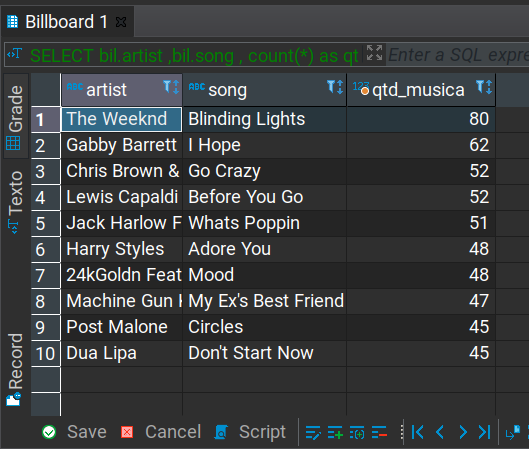

 Top 10 artistas

In [ ]:
SELECT 	bil.artist
	, count(*) as qtd_artista
FROM PUBLIC."Billboard" AS bil
group by bil.artist 
order by qtd_artista desc
limit 10;

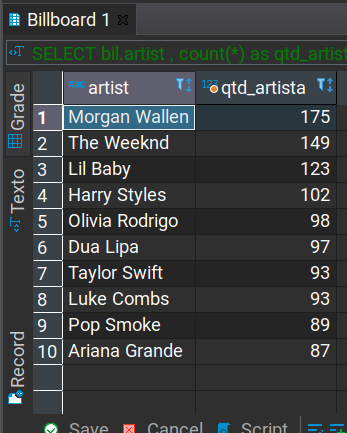

Usando CTEs para fazer subconsultas e junções
 - Quantas vezes o artista apareceu, quais sons e quantas vezes o som apareceu

In [ ]:
WITH cte_artist
AS (
	SELECT bil.artist
		,count(*) AS qtd_artist
	FROM PUBLIC."Billboard" AS bil
	GROUP BY bil.artist
	ORDER BY bil.artist
	)
	,cte_song
AS (
	SELECT bil.song
		,count(*) AS qtd_song
	FROM PUBLIC."Billboard" AS bil
	GROUP BY bil.song
	ORDER BY bil.song
	) 
SELECT DISTINCT bil.artist
,cta.qtd_artist
,bil.song
,cts.qtd_song FROM PUBLIC."Billboard" AS bil
LEFT JOIN cte_artist AS cta ON (bil.artist = cta.artist)
LEFT JOIN cte_song AS cts ON (bil.song = cts.song) 
ORDER BY bil.artist, qtd_song desc , bil.artist 

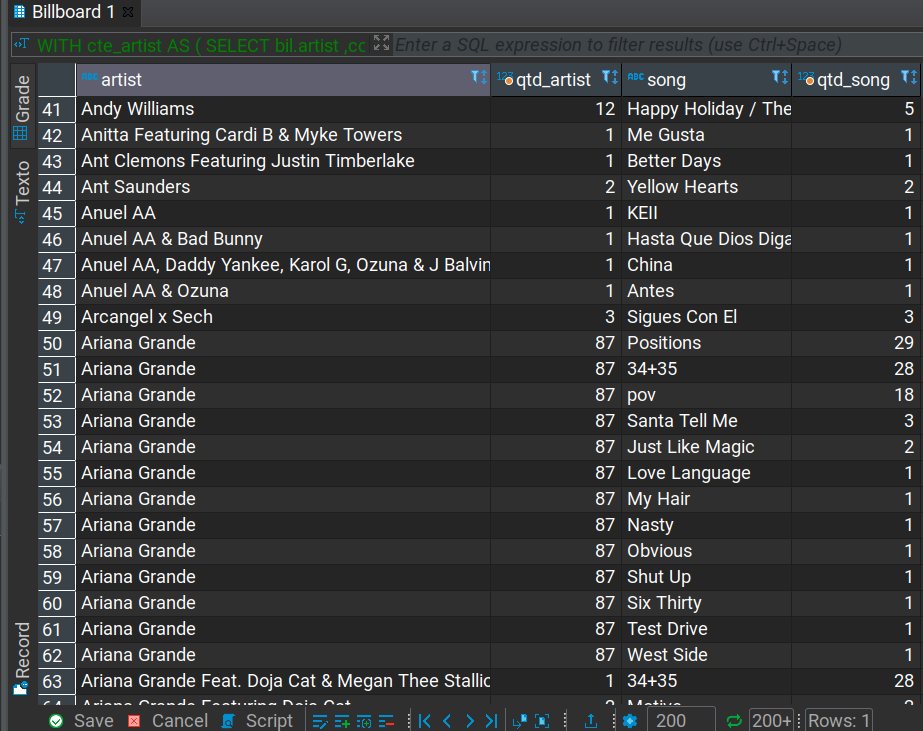

Criação de views
- Com a criação da view, pode-se conceder acesso a determinado usuário sem expor a base de dados inteira. Seu uso junto com os CTEs mantém a possibilidade de atualizar a view sem a necessidade de criar uma nova, desde que mantida sua estrutura


Quais artistas estiveram em primeiro lugar no ranking e quando?

In [ ]:
create view vw_artist
as(  
with cte_view as 
	(SELECT distinct bil.artist
	,bil."rank" 
	,bil."date" 
	FROM PUBLIC."Billboard" AS bil
	where bil."rank" = 1
	order by  bil.artist
)
	select ctw.artist
	,ctw."rank" 
	,ctw."date" 
	from cte_view as ctw 

);

Agora é só fazer a query da view:

In [ ]:
select * from vw_artist;

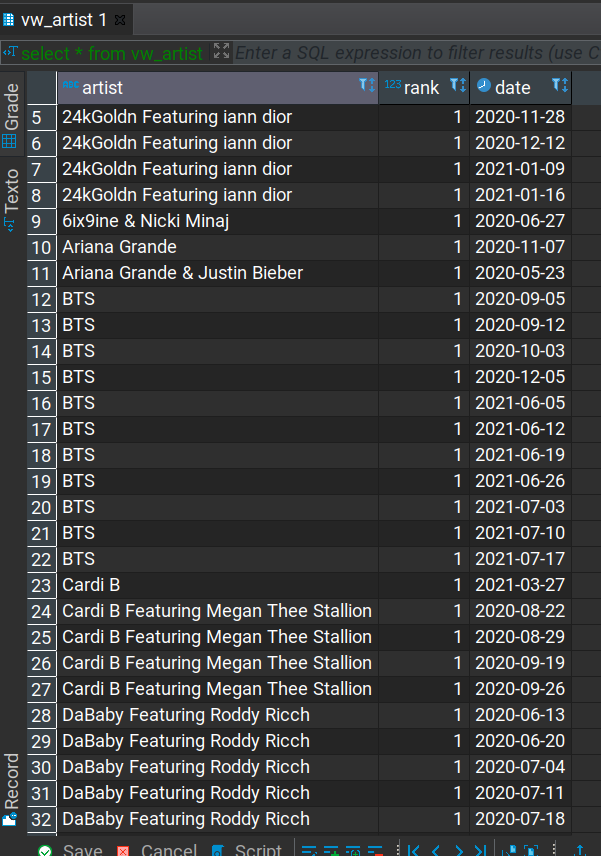

#  Ampliando as Possibilidades com Python + Sql

Para aumentar a possibilidade de análises a partir de queries no pandas ou fazer o cross data entre dataframes e tabelas, podemos usar dois pacotes que permitem executar queries a partir do script python. Para isso vamos precisar dos seguintes pacotes:
- Manter o pip atualizado.
- SQLAlchemy
- psycopg2
- psycopg2-binary



```
pip install --upgrade pip
pip install SQLAlchemy
pip install psycopg2
pip install psycopg2-binary

```




Feito a instalação dos pacotes, vamos ao código de exemplo:


In [ ]:
from sqlalchemy import create_engine
import pandas as pd

In [ ]:
engine = create_engine(
    'postgresql+psycopg2:user:password@hostname/database_name')
#aqui deve-se substituir os dados por suas credenciais de acesso ao banco de dados. Por questão de segurança, eu omiti as minhas. 

In [ ]:
#declaração da variável com a consulta a ser feita
sql='''
SELECT 	bil.artist
	, count(*) as qtd_artista
FROM PUBLIC."Billboard" AS bil
group by bil.artist 
order by qtd_artista desc
limit 10;
'''


In [ ]:
#Inserindo o resultado da query em um dataframe
df = pd.read_sql_query(sql,engine)
df.index+=1
df


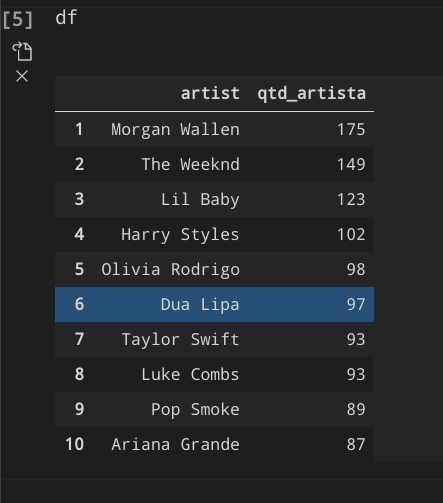

# Ferramenta de BI com o banco de dados

Para finalizar, vamos conectar a ferramenta de BI metabase em nosso banco de dados.

O que é o Metabase?

De acordo com o próprio site, o Metabase é “uma forma simples e open source para todos da sua empresa fazer perguntas e aprender por dados”.

Felizmente, o Metabase possui integraçao com o Heroku pois é Cloud Ready. Em alguns cliques tudo será implementado na nuvem. Até o momento (julho/2021), o serviço é gratuito.
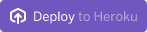



Após alguns minutos para o Deploy no Heroku, já é possível, configurar o setup da base de dados no metadata. Para isso, vamos usar nossas credenciais que estão no próprio app Postgres no heroku. Facilmente o Metabase conecta e já da algumas estatística de sua base de dados. 

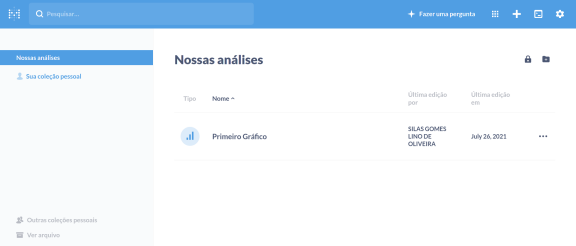

Com tudo na Nuvem, é possivel disponibilizar um Objeto ou um Dashboard público pelo Metabase. Ainda é possível trabalhar em equipes de BI.



Porém pelas limitações do plano gratuitoo serviço é preguiçoso 
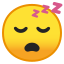




Quando não há acesso, o Heroku desativa o serviço e para acessá-lo é necessário uma certa insistência para acordá-lo. Nada que uns três F5 no navegador não resolva.  

Como demonstração. Um Link público de um gráfico gerado pela plataforma:

http://mtbsgl2021.herokuapp.com/public/question/68c1a889-4c49-42e1-8f97-a93fefe6da91

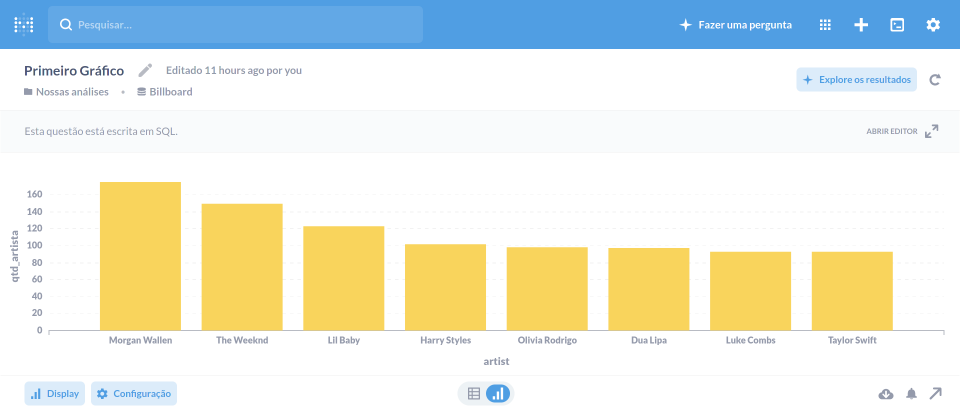